### Needed Imports

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
# Download the stopwords and tokenizer from nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from sklearn.naive_bayes import MultinomialNB


[nltk_data] Downloading package stopwords to /Users/Steve/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Steve/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Importing data and data manipulation



I was originally unsure how to manage the two data files since they seemed split already into "training" and "testing" data. After further development and analysis with the data, it appeared that the "Testing_Set" and "Training_Set" could be used as one data set combined. The only difference was the "Testing_Set" has the "Sentiment" column removed. After further analysis and understanding of the correlation between the "Sentiment" column and the "Label" column, I decided to generate a new column called "Sentiment" in the "Testing_Set" data frame with values equally "label" - 1. This allows me to combine both data sets and randomly train, test, split the data later in the assignment.

In [6]:
# Read in the two xls files
df = pd.read_excel('Legal_Sentences_For_Training_With_BERT_With_Label.xlsx')
print("Raw training set of legal documents")
display(df.head())
display(df.shape)

test_sentences_df = pd.read_excel('Testing_Set_Legal_Sentences.xlsx')
print("Raw Testing set of legal documents")
display(test_sentences_df.head())

# Relabel columns to match the other data frame
test_sentences_df['Phrase'] = test_sentences_df['sentence']
test_sentences_df['Label'] = test_sentences_df['label']

# Generate a new column for the sentiment with values corresponding to the labels - 1
test_sentences_df['Sentiment'] = test_sentences_df['label'] - 1
test_sentences_df = test_sentences_df.drop(['sentence', 'label'], axis=1)

print("Converted Testing set of legal documents to the same format as the training set.")
display(test_sentences_df.head())
display(test_sentences_df.shape)

# combine both dataframes
both_df = pd.concat([df, test_sentences_df])
display(both_df.head())
display(both_df.shape)

Raw training set of legal documents


,ID,Phrase,Sentiment,Label
0,1,Getting nowhere with surplusage,-1,0
1,2,But the Court nowhere suggested that it would ...,-1,0
2,3,Petitioners objection to shaving his beard cla...,-1,0
3,4,That result clashes with everything else,-1,0
4,5,the tolerable duration of police inquiries in ...,0,1


(576, 4)

Raw Testing set of legal documents


,ID,sentence,label
0,1,has done nothing to satisfy the probable-cause...,0
1,2,"Addressing that question here , the CCA referr...",1
2,3,standards and procedures,1
3,4,has no comprehension of why he has been single...,0
4,5,"an expert , Dr. Woods , who offered the opinio...",2


Converted Testing set of legal documents to the same format as the training set.


,ID,Phrase,Label,Sentiment
0,1,has done nothing to satisfy the probable-cause...,0,-1
1,2,"Addressing that question here , the CCA referr...",1,0
2,3,standards and procedures,1,0
3,4,has no comprehension of why he has been single...,0,-1
4,5,"an expert , Dr. Woods , who offered the opinio...",2,1


(500, 4)

,ID,Phrase,Sentiment,Label
0,1,Getting nowhere with surplusage,-1,0
1,2,But the Court nowhere suggested that it would ...,-1,0
2,3,Petitioners objection to shaving his beard cla...,-1,0
3,4,That result clashes with everything else,-1,0
4,5,the tolerable duration of police inquiries in ...,0,1


(1076, 4)

# EDA

After dealing with the missing values in the data, I decided to look at the distribution of the "Label" column. I wanted to see if the data was balanced or not. I found that the data was not balanced and that there were more "0" values than "-1" values. This is important to note because it will affect the accuracy of the model. The imbalance of negative sentiment, makes me understand that there are less "good" or "positive" words in the data set.  I also looked at the distribution of the "Sentiment" column and found that it was also not balanced, but that it had the same spread as the labels. This was important for me to understand and for my data aggregation because it allowed me to see that the "Sentiment" column was a good representation of the "Label" column and that I created it correctly.

As for the sentence length, it was interesting to see the distribution of the sentence lengths. A majority of the sentences lengths fell under 200 and between 50 and 100 at it's peak. There were a few outliers ranging into the upper 300's. This is important to consider because of the influence of the length of the sentence and it impacts accuracy when training the model.

In [164]:
# Checking for missing values in dfs 
print("Missing values when combining both datesets", both_df.isnull().sum())

Missing values when combining both datesets ID           0
Phrase       0
Sentiment    0
Label        0
dtype: int64


All labels for training data [0, 1, 2]
Occurances per labels above [493, 290, 293]


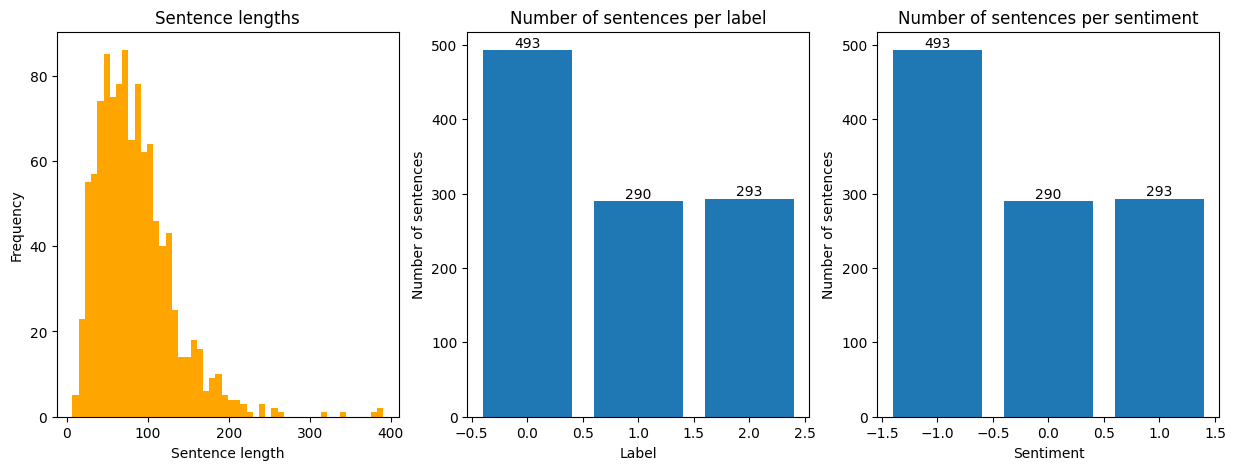

In [21]:
# Creating plot of sentence lengths, to see if there are any outliers
sentences = list(both_df['Phrase'])
sentence_lengths = [len(sentence) for sentence in sentences]

# Plotting the sentence lengths in a histogram
# using tuple unpacking for multiple Axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# ax1.subplot(1,2,1)
ax1.hist(sentence_lengths, bins=50, color='orange')
ax1.set_xlabel('Sentence length')
ax1.set_ylabel('Frequency')
ax1.set_title('Sentence lengths')


# Plot 2
# List of the unique labels and the number of sentences per label
labels = list(both_df['Label'].unique())
print("All labels for training data", labels)
num_sentences = [len(both_df[both_df['Label']==label]) for label in labels]
print("Occurances per labels above", num_sentences)

# Plotting the number of sentences per label
ax2.bar(labels, num_sentences)
# adding a value above each bar
for i in range(len(labels)):
    ax2.text(labels[i], num_sentences[i], num_sentences[i], ha='center', va='bottom')
ax2.set_xlabel('Label')
ax2.set_ylabel('Number of sentences')
ax2.set_title('Number of sentences per label')

# Plot 3
# List of the unique sentiment labels and the number of sentences per Sentiment column name
sentiment_labels = list(both_df['Sentiment'].unique())
sent_num_sentences = [len(both_df[both_df['Sentiment']==label]) for label in sentiment_labels]

# Plotting umber of sentences per Sentiment column name
ax3.bar(sentiment_labels, sent_num_sentences)
# adding a value above each bar
for i in range(len(labels)):
    ax3.text(sentiment_labels[i], sent_num_sentences[i], sent_num_sentences[i], ha='center', va='bottom')
ax3.set_xlabel('Sentiment')
ax3.set_ylabel('Number of sentences')
ax3.set_title('Number of sentences per sentiment')

plt.show()


# Preprocess the data

Preprocessing data is essentially to getting optimal model results. I used a modular approach and created a function to process each "Phrase" row in the data. I first began with tokenizing the text which better helped identify sets of words and distinguish puntuation more properly. I also lowered all the words and removing the following: punctuation, stopwords, and duplicate words. I was hesitant with removing duplicate words, but I was satisfied with the results I was able to produce.

In [24]:
def preprocess_text(text):
    # Convert text to lowercase
    words = word_tokenize(text)

    # Convert words to lowercase
    words = [word.lower() for word in words]

    # Remove punctuation from words
    words = [word for word in words if word.isalnum()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Remove duplicate words
    unique_words = list(dict.fromkeys(words))

    # Join the words back into a string
    text = ' '.join(unique_words)

    return text

#  Used to create a token count column
def get_token_count(text):
    words = word_tokenize(text)
    return len(words)

# Used to get the list of unqiue words of a row
def get_unique_words(text):
    words = word_tokenize(text)
    unique_words = list(dict.fromkeys(words))
    return unique_words

# Used to get the count of list of unqiue words of a row
def get_unique_token_count(text):
    words = word_tokenize(text)
    unique_words = list(dict.fromkeys(words))
    return len(unique_words)


In [25]:
# Preprocess the text and store the processed text in a new column, and the token count in another column
both_df['processed_phrase'] = both_df['Phrase'].apply(preprocess_text)
both_df['processed_phrase_token_count'] = both_df['processed_phrase'].apply(get_token_count) 
display(both_df.head())

,ID,Phrase,Sentiment,Label,processed_phrase,processed_phrase_token_count
0,1,Getting nowhere with surplusage,-1,0,getting nowhere surplusage,3
1,2,But the Court nowhere suggested that it would ...,-1,0,court nowhere suggested would narrow bivens ex...,8
2,3,Petitioners objection to shaving his beard cla...,-1,0,petitioners objection shaving beard clashes ar...,10
3,4,That result clashes with everything else,-1,0,result clashes everything else,4
4,5,the tolerable duration of police inquiries in ...,0,1,tolerable duration police inquiries context de...,7


# Semantic Analysis

#### Getting unique words from the corpus


In [29]:
# Adding uqniue words and unique word count to the dataframe
both_df['unique_words'] = both_df['processed_phrase'].apply(get_unique_words) 
both_df['unique_w_count'] = both_df['processed_phrase'].apply(get_unique_token_count) 
display(both_df.head())


,ID,Phrase,Sentiment,Label,processed_phrase,processed_phrase_token_count,unique_words,unique_w_count
0,1,Getting nowhere with surplusage,-1,0,getting nowhere surplusage,3,"[getting, nowhere, surplusage]",3
1,2,But the Court nowhere suggested that it would ...,-1,0,court nowhere suggested would narrow bivens ex...,8,"[court, nowhere, suggested, would, narrow, biv...",8
2,3,Petitioners objection to shaving his beard cla...,-1,0,petitioners objection shaving beard clashes ar...,10,"[petitioners, objection, shaving, beard, clash...",10
3,4,That result clashes with everything else,-1,0,result clashes everything else,4,"[result, clashes, everything, else]",4
4,5,the tolerable duration of police inquiries in ...,0,1,tolerable duration police inquiries context de...,7,"[tolerable, duration, police, inquiries, conte...",7


### Skip-mdoel for words2vec

This method allowed me to see how well does in evaluate semantic similarity. One of the limitations when comparing this method is that, after preprocessing, the data is not as robust as it could be. I had trouble finding words really similar to a generic word like "good", but did see similar scores with other words using "good" as a reference. For example, words like laws, liberty, and supreme were rated similar to each other, and neatural words like probable and well were also rated similar but on a more slightly negatively baised scale. Based on the limited data and pesamistic data set, I would say that the understanding that "good" and "well" is not quite where it could be.

In [31]:
# Create skip-gram model on the processed phrases
tokenized_texts = [word_tokenize(text) for text in both_df['processed_phrase']]
skipgram_model = Word2Vec(tokenized_texts, vector_size=100, window=5, min_count=1, sg=1)
print("Skip-gram model vocabulary size:", len(skipgram_model.wv))

# Test semantic similarity using the Skip-gram model
word1 = "good"
word2 = ["supreme", "tragic", "probable", "laws","police", "liberty", "well"]

for word in word2: 
    print("Semantic similarity between '{}' and '{}':".format(word1, word), skipgram_model.wv.similarity(word1, word))


Skip-gram model vocabulary size: 3160
Semantic similarity between 'good' and 'supreme': 0.03997123
Semantic similarity between 'good' and 'tragic': 0.17507191
Semantic similarity between 'good' and 'probable': -0.04661958
Semantic similarity between 'good' and 'laws': 0.081615895
Semantic similarity between 'good' and 'police': -0.018455809
Semantic similarity between 'good' and 'liberty': 0.020047512
Semantic similarity between 'good' and 'well': -0.04357647


# Sentiment Analysis

In [32]:
# Created function to convert the rating scale to sentiment labels
def convert_sentiment_to_string(sentiment):
  if sentiment == -1:
    return 'negative'
  elif sentiment == 0:
    return 'neutral'
  else:
    return 'positive'

### Adding setiment label column to data

In [34]:
both_df['sentiment_label'] = both_df['Sentiment'].apply(convert_sentiment_to_string)
display(both_df.head())

,ID,Phrase,Sentiment,Label,processed_phrase,processed_phrase_token_count,unique_words,unique_w_count,sentiment_label
0,1,Getting nowhere with surplusage,-1,0,getting nowhere surplusage,3,"[getting, nowhere, surplusage]",3,negative
1,2,But the Court nowhere suggested that it would ...,-1,0,court nowhere suggested would narrow bivens ex...,8,"[court, nowhere, suggested, would, narrow, biv...",8,negative
2,3,Petitioners objection to shaving his beard cla...,-1,0,petitioners objection shaving beard clashes ar...,10,"[petitioners, objection, shaving, beard, clash...",10,negative
3,4,That result clashes with everything else,-1,0,result clashes everything else,4,"[result, clashes, everything, else]",4,negative
4,5,the tolerable duration of police inquiries in ...,0,1,tolerable duration police inquiries context de...,7,"[tolerable, duration, police, inquiries, conte...",7,neutral


## Model Training and Testing

Term Frequency-Inverse Document Frequency (TF-IDF), is used to convert text data into a numerical format, preserving important textual characteristics in a way that can be easily used by algorithms.

In [53]:
# Using most processed phrases to create a TF-IDF vectorizer
X = both_df['processed_phrase'].values
y = both_df['sentiment_label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
display(X_train.shape)
display(X_test.shape)

# Creating a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

display(X_train_tfidf.shape)
display(X_test_tfidf.shape)

(807,)

(269,)

(807, 2681)

(269, 2681)

### Predicting using Naive Bayes Classifier

Evaluate the performance of the sentiment analysis model using appropriate metrics (e.g., accuracy, precision, recall).  
Interpret the results and discuss the challenges and limitations of sentiment analysis in this context.  

The limi

Summary: 
Accuracy: 0.48
Precision: 0.5
Recall: 0.48
F1 Score: 0.39
AUC-ROC Score: 0.67

In [46]:
# Fit and Train using a Naive Bayes Classifier 
classifier = MultinomialNB()
classifier.fit(X_train_tfidf, y_train)

# Test the classifier model 
y_pred = classifier.predict(X_test_tfidf)
display(y_pred)
display(len(y_pred))

array(['negative', 'negative', 'positive', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'positive',
       'negative', 'negative', 'negative', 'negative', 'positive',
       'negative', 'positive', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'neutral', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'neutral', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'positive', 'positive', 'negative', 'negative', 'negative

269

#### Evaluation Metrics

Overall the results weren't that great, the model produced results that we no better than flipping a coin. I don't think enough training data nor the model was robust enough to produce better results. I think the model could be improved by using a different model like a neural network or a different classifier. With such a small dataset, the impacts of irony or sarcasm could be a limiting factor as to why resutls were labeled as sarcastic or ironic. Whoever labeled the dataset could have also been biased in their labeling and could have labeled the data incorrectly.

In [54]:
def eval_metrics(X_test_tfidf, y_test, y_pred_tfidf, clf):
  # Evaluate using classification metrics
  accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
  precision_tfidf = precision_score(y_test, y_pred_tfidf, average='weighted')
  recall_tfidf = recall_score(y_test, y_pred_tfidf, average='weighted')
  f1_score_tfidf = f1_score(y_test, y_pred_tfidf, average='weighted')

  # Using predict_proba which peformed similar results to decision_function()
  roc_auc_tfidf = roc_auc_score(y_test, clf.predict_proba(X_test_tfidf), multi_class='ovr')

  # Display the classification metrics
  print(f"Accuracy: {accuracy_tfidf:.2}")
  print(f"Precision: {precision_tfidf:.2}")
  print(f"Recall: {recall_tfidf:.2}")
  print(f"F1 Score: {f1_score_tfidf:.2}")
  print(f"AUC-ROC Score: {roc_auc_tfidf:.2}")
  print(classification_report(y_test, y_pred_tfidf, target_names=["negative", "neutral", "positive"]))

In [55]:
# Evaluate the Naive Bayes classifier
print(f"Sentiment Analysis Classifier metrics (using Naive Bayes Classifier):")
eval_metrics(X_test_tfidf, y_test, y_pred, classifier)

Sentiment Analysis Classifier metrics (using Naive Bayes Classifier):
Accuracy: 0.48
Precision: 0.5
Recall: 0.48
F1 Score: 0.39
AUC-ROC Score: 0.67
              precision    recall  f1-score   support

    negative       0.47      0.90      0.62       121
     neutral       0.54      0.09      0.16        76
    positive       0.52      0.18      0.27        72

    accuracy                           0.48       269
   macro avg       0.51      0.39      0.35       269
weighted avg       0.50      0.48      0.39       269



## Reflecting with an Application

Using semantic and sentiment analyis has enabled busniess to anlayze customers at scale much more easily. They can understand what habits and trends are happening to target consumer consumption. This is important because it allows businesses to understand what their customers are thinking and how they feel about their products. This allows businesses to make better decisions and improve their products and services.

For example, if a busniess sees there is a negative sentiment towards one of their products, they can quickly summarize why their product is not doing well and make changes to improve it. They could also search their social media platforms to see which one of their products gets talked about the most after a marketing campaign. 